# Setup

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
from tensorflow import keras
from keras import layers
from unet_clonable import *
from diffusion_model import *
import math
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)

C:\Users\yijian bai\.conda\envs\tf2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
C:\Users\yijian bai\.conda\envs\tf2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperparameters

In [2]:
# architecture of attention unet
image_size = 64
widths = [32, 64, 96, 128]
block_depth = 2
diffusion_steps = 1000
# optimization
batch_size = 64
learning_rate = 1e-3
weight_decay = 1e-4
checkpoint_path = "checkpoints/diffusion_model/diffusion_steps_%d_chanel%d_attention_%d"%(diffusion_steps,max(widths),min(Attn_resolutions))

#other hyperparameters of model are stored at diffusion_model.py

# Data Pipeline

In [3]:
# load dataset
#could setting in diffusion model.py
train_dataset_example ,train_dataset, info = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]", with_info=True)
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

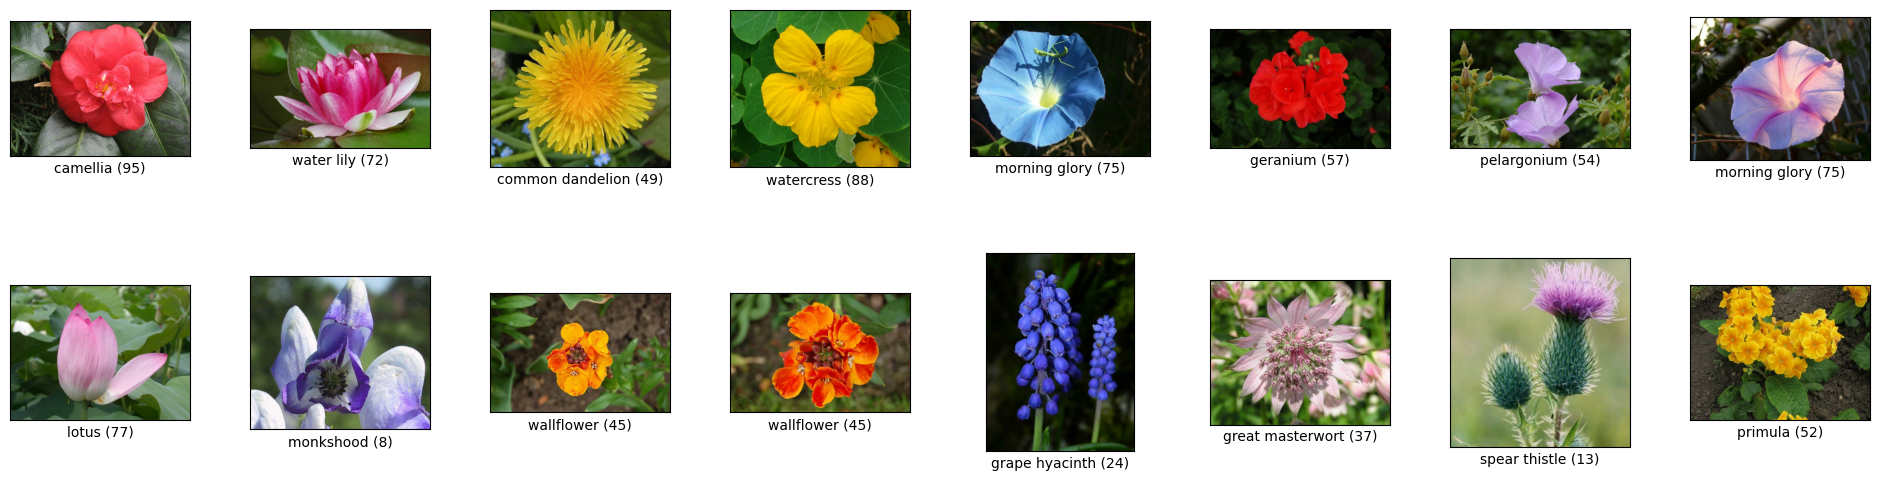

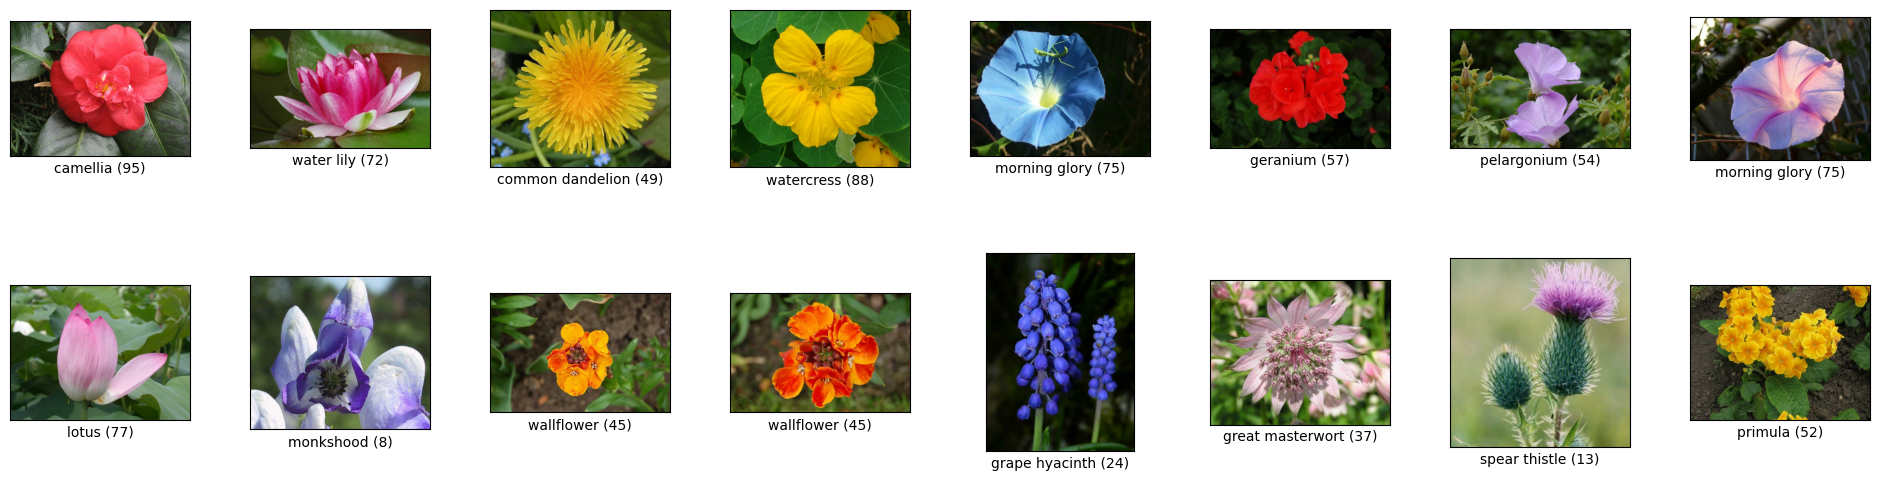

In [4]:
tfds.show_examples(train_dataset_example, info, rows=2, cols=8)

# inference

In [5]:
model2 = DiffusionModel(image_size, widths, block_depth, diffusion_steps=diffusion_steps)
model2.normalizer.adapt(train_dataset)
model2.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay),
    loss=keras.losses.mean_absolute_error,  # pixelwise mean absolute error is used as loss, mse also ok
)
# load the best model and generate images
model2.load_weights(checkpoint_path)

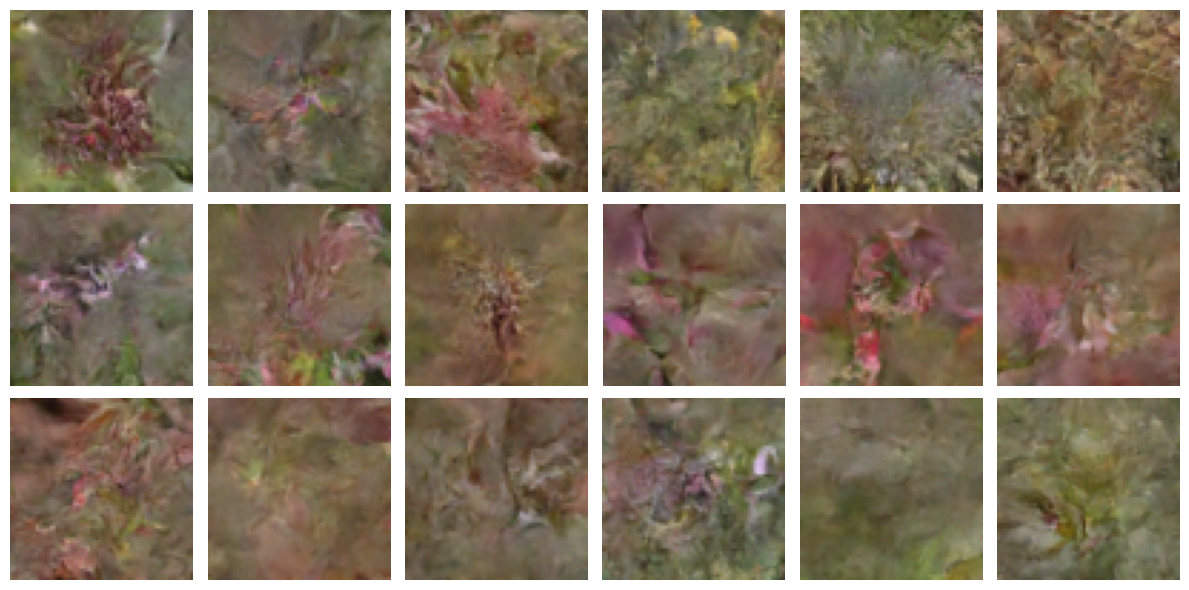

In [6]:
model2.plot_images(plot_diffusion_steps = int(0.5*diffusion_steps), epoch=0)

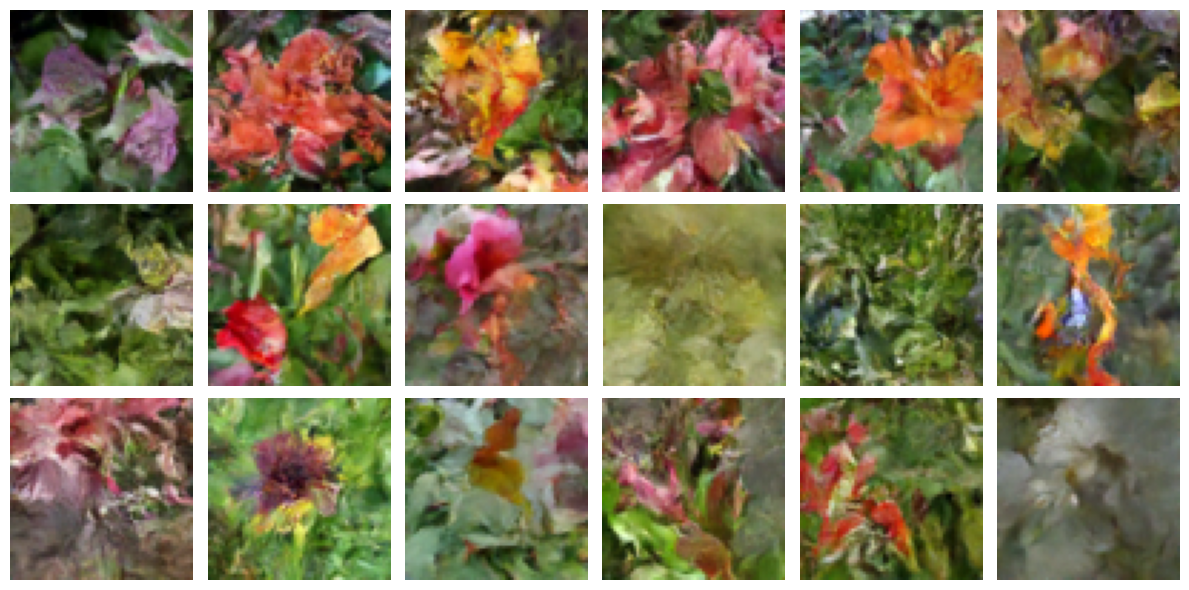

In [7]:
model2.plot_images(plot_diffusion_steps = int(0.7*diffusion_steps), epoch=0)

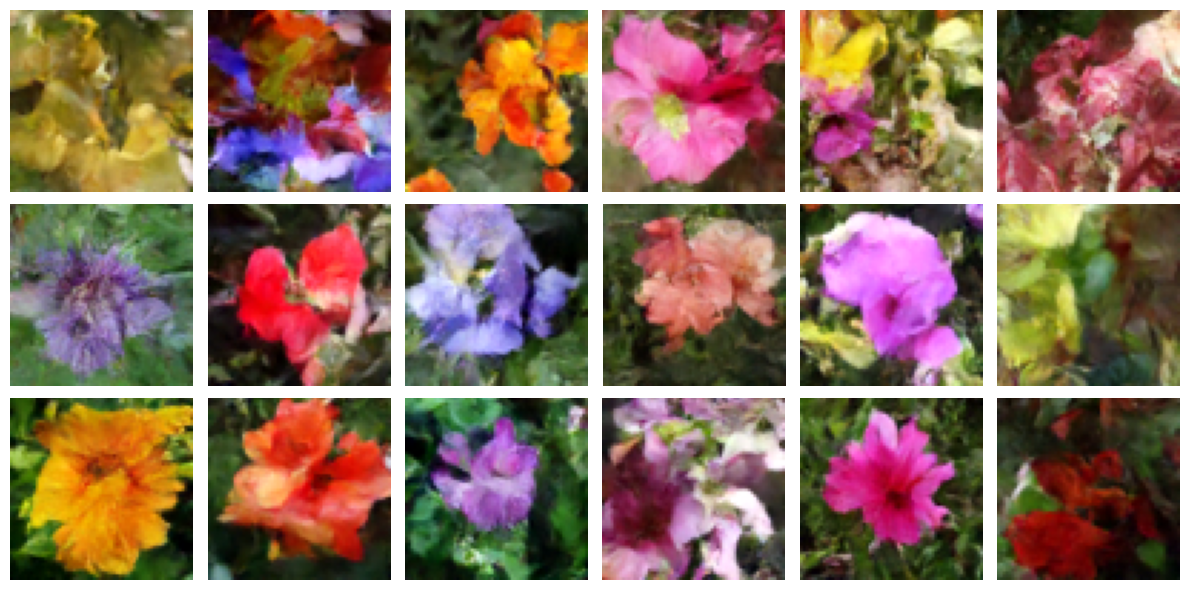

In [8]:
model2.plot_images(plot_diffusion_steps=int(0.9*diffusion_steps), epoch=0)

# Metrics vs diffusion step

In [9]:
@tf.function
def get_fid_score(real_image, gen_image):
    size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
    resized_real_images = tf.image.resize(real_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    resized_generated_images = tf.image.resize(gen_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    fid = tfgan.eval.frechet_inception_distance(resized_real_images, resized_generated_images)
    return fid

@tf.function
def get_inception_score(images):
    size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE
    resized_images = tf.image.resize(images, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    inc_score = tfgan.eval.inception_score(resized_images)
    return inc_score

def get_psnr(real, generated):
    psnr_value = tf.reduce_mean(tf.image.psnr(generated, real, max_val=1.0))
    return psnr_value


realimg = next(iter(val_dataset))

## FID

In [10]:
fid_list=[]
for i in range(1,diffusion_steps,20):
    fid_list.append(get_fid_score(realimg,model2.generate(num_images=batch_size,diffusion_steps=i)))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
C:\Users\yijian bai\.conda\envs\tf2\lib\site-packages\keras\legacy_tf_layers\core.py:513: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
C:\Users\yijian bai\.conda\envs\tf2\lib\site-packages\keras\engine\base_layer.py:2215: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\yijian bai\.conda\envs\tf2\lib\site-packages\keras\engine\base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` a

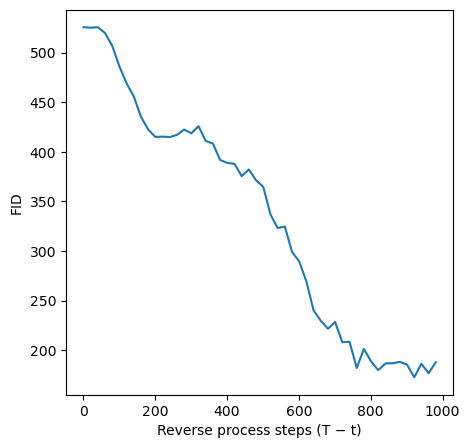

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(5, 5))
plt.plot(range(1,diffusion_steps,20),fid_list)
plt.xlabel('Reverse process steps (T − t)')
plt.ylabel('FID')
plt.show()
plt.savefig('FID.png')

## PSNR

In [12]:
psnr_list=[]
for i in range(1,diffusion_steps,20):
    psnr_sum = 0
    generated_imgaes = model2.image_denoising_t(realimg, i)
    for j in range(len(realimg)):
        psnr_sum = psnr_sum + get_psnr(realimg[j], generated_imgaes[j])
    psnr_list.append(psnr_sum/len(realimg))

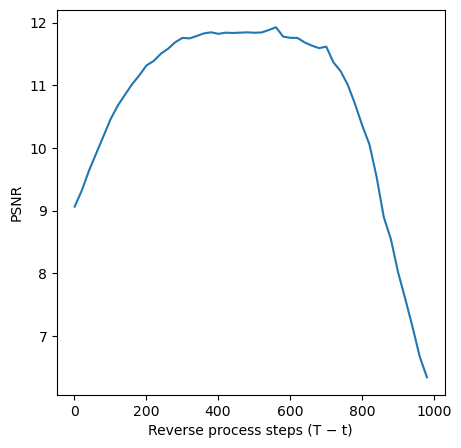

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(5, 5))
plt.plot(range(1,diffusion_steps,20),psnr_list)
plt.xlabel('Reverse process steps (T − t)')
plt.ylabel('PSNR')
plt.show()
plt.savefig('PSNR.png')

## IS

In [14]:
is_list=[]
for i in range(1,diffusion_steps,20):
    is_list.append(get_inception_score(model2.generate(num_images=batch_size,diffusion_steps=i)))

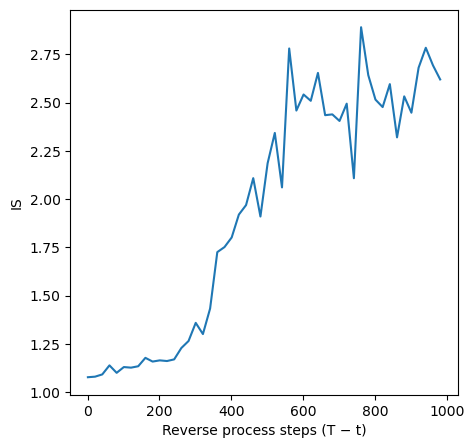

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(5, 5))
plt.plot(range(1,diffusion_steps,20),is_list)
plt.xlabel('Reverse process steps (T − t)')
plt.ylabel('IS')
plt.show()
plt.savefig('IS.png')

## KID

In [16]:
kid_m=KID(name="val")
kid_list=[]
for i in range(1,diffusion_steps,20):
    kid_m.update_state(realimg, model2.generate(num_images=batch_size,diffusion_steps=i))
    kid_list.append(kid_m.result())

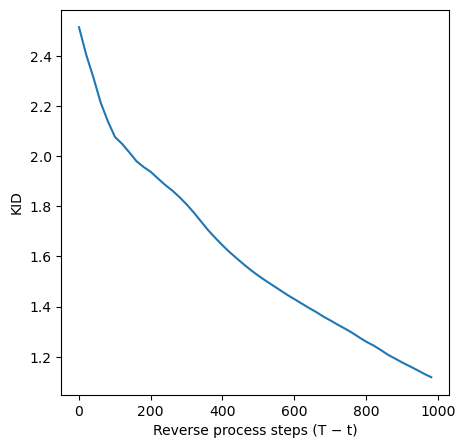

In [17]:
plt.figure(figsize=(5, 5))
plt.plot(range(1,diffusion_steps,20),kid_list)
plt.xlabel('Reverse process steps (T − t)')
plt.ylabel('KID')
plt.show()